In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from cmdstanpy import CmdStanModel
import cmdstanpy
import arviz as az
import pandas as pd
import csv,re

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200

In [2]:
LIGHT = "#B3FFFF"  # 179, 255, 255,
LIGHT_HIGHLIGHT = "#9AF6FF"  # 154, 246,255
MID = "#67C3FF"  # 103,195,255
MID_HIGHLIGHT = "#3490CC"  # 52,144,204
DARK = "#015D99"  # 1,93,153
DARK_HIGHLIGHT = "#002A66"  # 0,42,102
GREEN = "#00FF00"  # RGB
LIGHT_GREY = "#DDDDDD"  # RGB

In [3]:
acc_healthy = pd.read_csv('data_new_preprocessed/acc_healthy_samples.csv')
acc_15 = pd.read_csv('data_new_preprocessed/acc_15_samples.csv')
acc_35 = pd.read_csv('data_new_preprocessed/acc_35_samples.csv')

gyro_healthy = pd.read_csv('data_new_preprocessed/gyro_healthy_samples.csv')
gyro_15 = pd.read_csv('data_new_preprocessed/gyro_15_samples.csv')
gyro_35 = pd.read_csv('data_new_preprocessed/gyro_35_samples.csv')

gyro_agg_healthy = pd.read_csv('data_new_preprocessed/gyro_agg_healthy_samples.csv')
gyro_agg_15 = pd.read_csv('data_new_preprocessed/gyro_agg_15_samples.csv')
gyro_agg_35 = pd.read_csv('data_new_preprocessed/gyro_agg_35_samples.csv')

In [4]:
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])
acc_15_data = np.array([acc_15[col].values for col in acc_15.columns if col.startswith('Sample')])
acc_35_data = np.array([acc_35[col].values for col in acc_35.columns if col.startswith('Sample')])
acc = [acc_healthy_data,acc_15_data,acc_35_data]

gyro_healthy_data = np.array([gyro_healthy[col].values for col in gyro_healthy.columns if col.startswith('Sample')])
gyro_15_data = np.array([gyro_15[col].values for col in gyro_15.columns if col.startswith('Sample')])
gyro_35_data = np.array([gyro_35[col].values for col in gyro_35.columns if col.startswith('Sample')])
gyro = [gyro_healthy_data,gyro_15_data,gyro_35_data]

gyro_agg_healthy_data = np.array([gyro_agg_healthy[col].values for col in gyro_agg_healthy.columns if col.startswith('Sample')])
gyro_agg_15_data = np.array([gyro_agg_15[col].values for col in gyro_agg_15.columns if col.startswith('Sample')])
gyro_agg_35_data = np.array([gyro_agg_35[col].values for col in gyro_agg_35.columns if col.startswith('Sample')])
gyro_agg = [gyro_agg_healthy_data, gyro_agg_15_data, gyro_agg_35_data]

In [5]:
len(acc[0]) +len(acc[1]) + len(acc[2])

158

In [35]:
def prepare_data(data_array,spl_order = 3, num_knots = 30, frequencies = None, 
                 mode = 'binary', training_samples = [10,10],lambda0=None):
    N = len(data_array[0][0])
    spl_order = spl_order
    num_knots = num_knots
    if frequencies is None:
        times = np.linspace(0,N*10,N)
        knot_list = np.quantile(times,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, times, spl_order, num_knots)

    else:
        knot_list = np.quantile(frequencies,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, frequencies, spl_order, num_knots)

    K = num_knots+2
    if mode == 'binary':
        M = 2
        IL1 = training_samples[0]
        IL2 = training_samples[1]
        IL = IL1+IL2

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])+len(data_array[2])
        data_array_damaged = np.concatenate([data_array[1], data_array[2]])
        total = num_healthy + num_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array_damaged)[sampling_order_2[:IL2]]])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array_damaged)[sampling_order_2[IL2:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL)])

        IT = y_test.shape[1]

    if mode == 'all':
        M = 3
        IL1 = training_samples[0]
        IL2 = training_samples[1]
        IL3 = training_samples[2]
        IL = IL1+IL2+IL3

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])
        num_very_damaged = len(data_array[2])

        total = num_healthy + num_damaged + num_very_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])
        sampling_order_3 = np.random.permutation([*range(num_very_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array[1])[sampling_order_2[:IL2]],
            np.array(data_array[2])[sampling_order_3[:IL3]],
            ])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2), 3*np.ones(IL3)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array[1])[sampling_order_2[IL2:]],
                np.array(data_array[2])[sampling_order_3[IL3:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2),3*np.ones(num_very_damaged-IL3)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL), (IL3)/(IL)])

        IT = y_test.shape[1]

    data_out = {
    "N": N,
    "IL": IL,
    "K": K,
    "M": M,
    "x": B0,
    "labels": labels,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "y_test": y_test,
    }

    return data_out, y_test_labels, IT, IL, total, B0, knot_list,N
    

def get_results(model, data, labels, IT, IL, total, mode = 'binary',plot = False, seed = None, N=None):
    if not seed:
        seed = np.random.randint(0,100000)
    if mode == 'binary':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b)/(total-IL)
        print('hit rate = ',hit_rate)
    if mode == 'all':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2
        indices_cat3 = labels == 3

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3 = probs_from_arviz.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3p = probs_from_arviz_p.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))
        c = sum((cat3["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b+c)/(total-IL)
        print('hit rate = ',hit_rate)

    if plot and mode == 'binary':
        fig, ax = plt.subplots(2,1,figsize=(12,8),tight_layout=True)

        x = np.arange(1,len(cat1p)+1)
        ax[0].scatter(x, (cat1p["mean"].values))
        ax[0].errorbar(x, cat1p["mean"].values, np.abs([cat1p["mean"].values-cat1p["hdi_3%"].values,
                    cat1p["hdi_97%"].values-cat1p["mean"].values]), linestyle='none')


        x = np.arange(1,len(cat2p)+1)
        ax[1].scatter(x, (cat2p["mean"].values))
        ax[1].errorbar(x, cat2p["mean"].values, np.abs([cat2p["mean"].values-cat2p["hdi_3%"].values,
                    cat2p["hdi_97%"].values-cat2p["mean"].values]), linestyle='none')



        ax[0].set_title('Healthy', loc='left',fontsize = 20)
        ax[0].set_ylabel('Probability',fontsize=16)
        ax[1].set_title('Damaged', loc='left',fontsize = 20)
        ax[1].set_ylabel('Probability',fontsize=16)
        ax[0].set_xticks([1,len(cat1p)])
        ax[1].set_xticks([1,len(cat2p)])
        ax[0].set_ylim([-0.05,1.05])
        ax[0].set_yticks([0,1])
        ax[1].set_ylim([-0.05,1.05])
        ax[1].set_yticks([0,1])
        ax[1].set_xlabel('Sample number',fontsize=16)
        fig.savefig('plots/ex_clas.jpg')

        # x = np.linspace(0,150,N)
        # fig = plt.figure(figsize=(12, 8), tight_layout = True)
        # axes = plt.subplot(1, 1 ,1)
        # y_pred= result.stan_variable('y_pred')[:,:]
        # axes = ribbon_plot(x,y_pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
        # axes.set_xlabel('Time [ms]',fontsize = 15)
        # axes.set_ylabel('Amplitude',fontsize = 15)
        # axes.set_title('Posterior predictive check', loc= 'left',fontsize = 20)
        # axes.plot(x,acc_healthy_data[0], color = 'k',alpha=0.8)
    # if plot and mode == 'all':
    if mode == 'binary':
        return hit_rate,[indices_cat1,indices_cat2]
    else:
        return hit_rate,[indices_cat1,indices_cat2,indices_cat3]
        

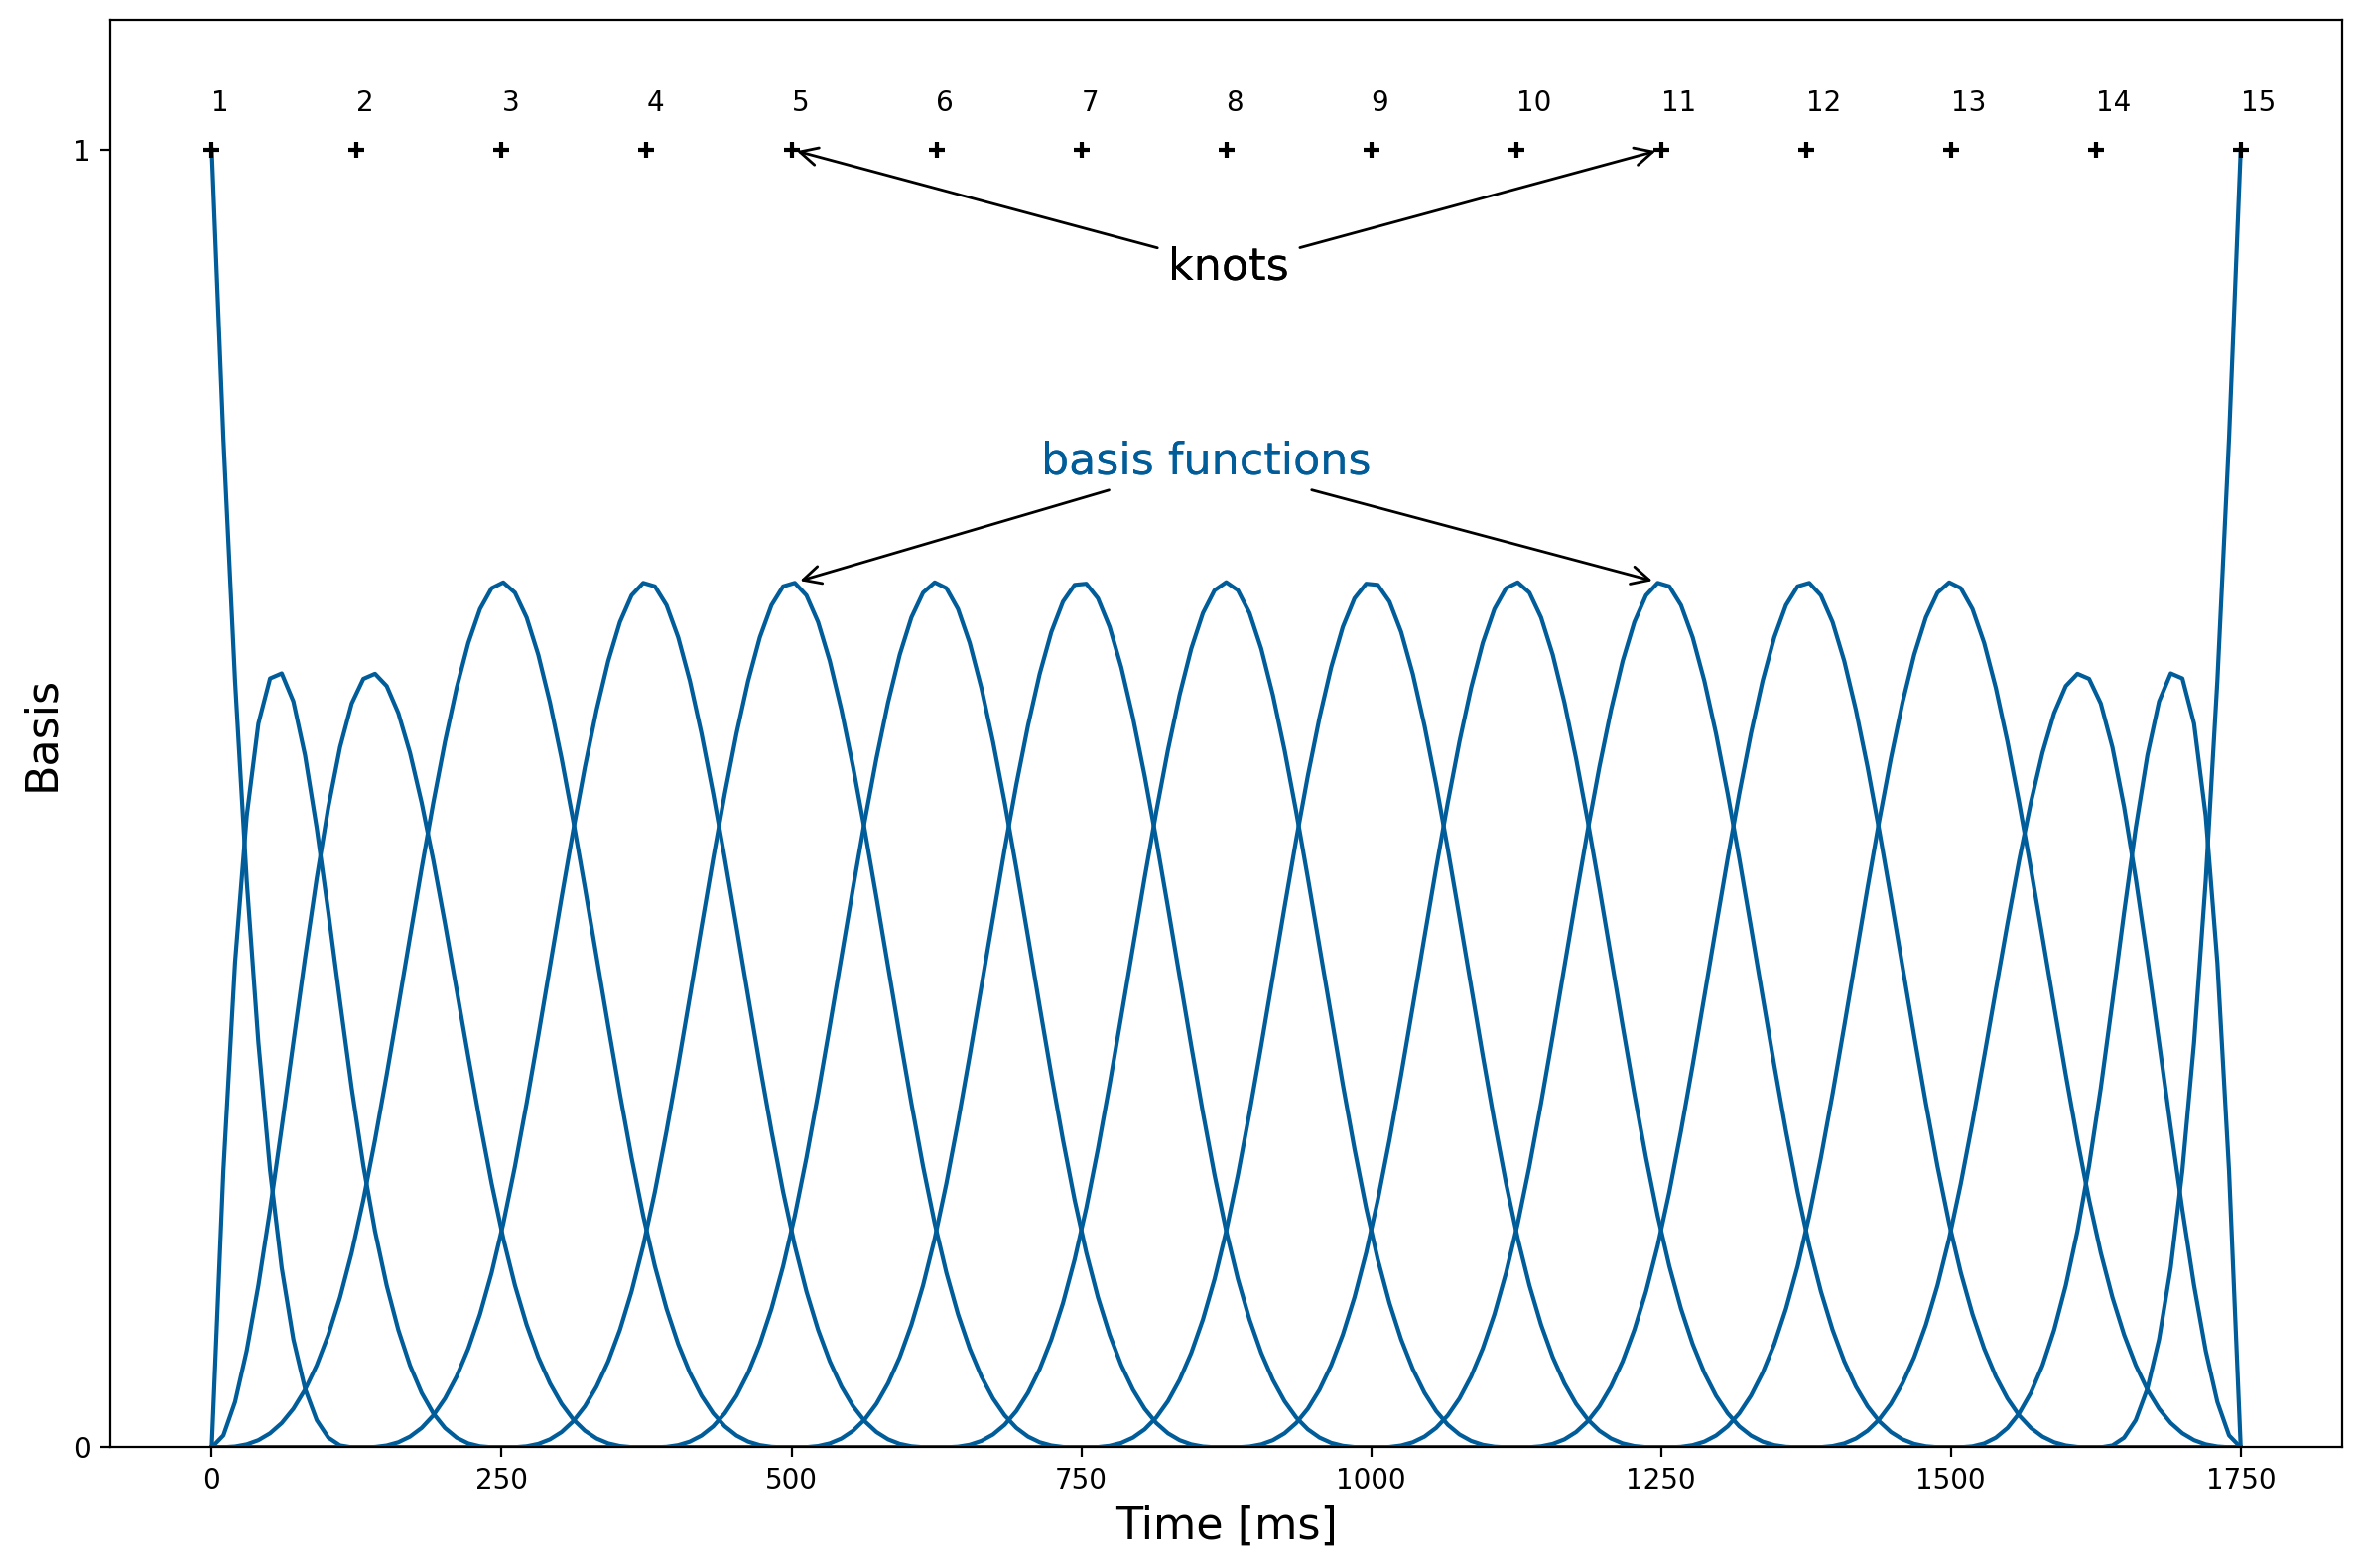

In [7]:
times = np.linspace(0,175*10,175)
knot_list = np.quantile(times,np.linspace(0,1,15))
B0 = create_spline_matrix(175, times, 3, 15)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
for i in range(15 + 2):
    ax.plot(times, (B0[:, i]), color=DARK, zorder=0)
    if i < 15:
        ax.text(s="{}".format(i + 1), x=knot_list[i] - 0.05, y=1.03)
        ax.scatter(knot_list[i], 1, marker="+", color="black", zorder=1)
ax.set_yticks([0, 1])
ax.set_ylim((0, 1.1))
ax.annotate(
    text="knots",
    xy=(knot_list[4], 1),
    xytext=(knot_list[6]+75, 0.9),
    arrowprops={"arrowstyle": "->"},fontsize=16
)
ax.annotate(
    text="knots",
    xy=(knot_list[10], 1),
    xytext=(knot_list[6]+75, 0.9),
    arrowprops={"arrowstyle": "->"},fontsize=16
)

ax.annotate(
    text="basis functions",
    xy=(times[np.argmax(B0[:, 5])], np.max(B0[:, 3])),
    xytext=(knot_list[5]+90, 0.75),
    arrowprops={"arrowstyle": "->"},
    c=DARK,fontsize=16
)
ax.annotate(
    text="basis functions",
    xy=(times[np.argmax(B0[:, 11])], np.max(B0[:, 8])),
    xytext=(knot_list[5]+90, 0.75),
    arrowprops={"arrowstyle": "->"},
    c=DARK,
    fontsize=16
)


ax.set_xlabel("Time [ms]", fontsize=16)
ax.set_ylabel("Basis", fontsize=16)
#fig.savefig("spline_base.pdf", bbox_inches="tight")
fig.savefig('plots/spline_basis.jpg')


13:02:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:02:51 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9444444444444444


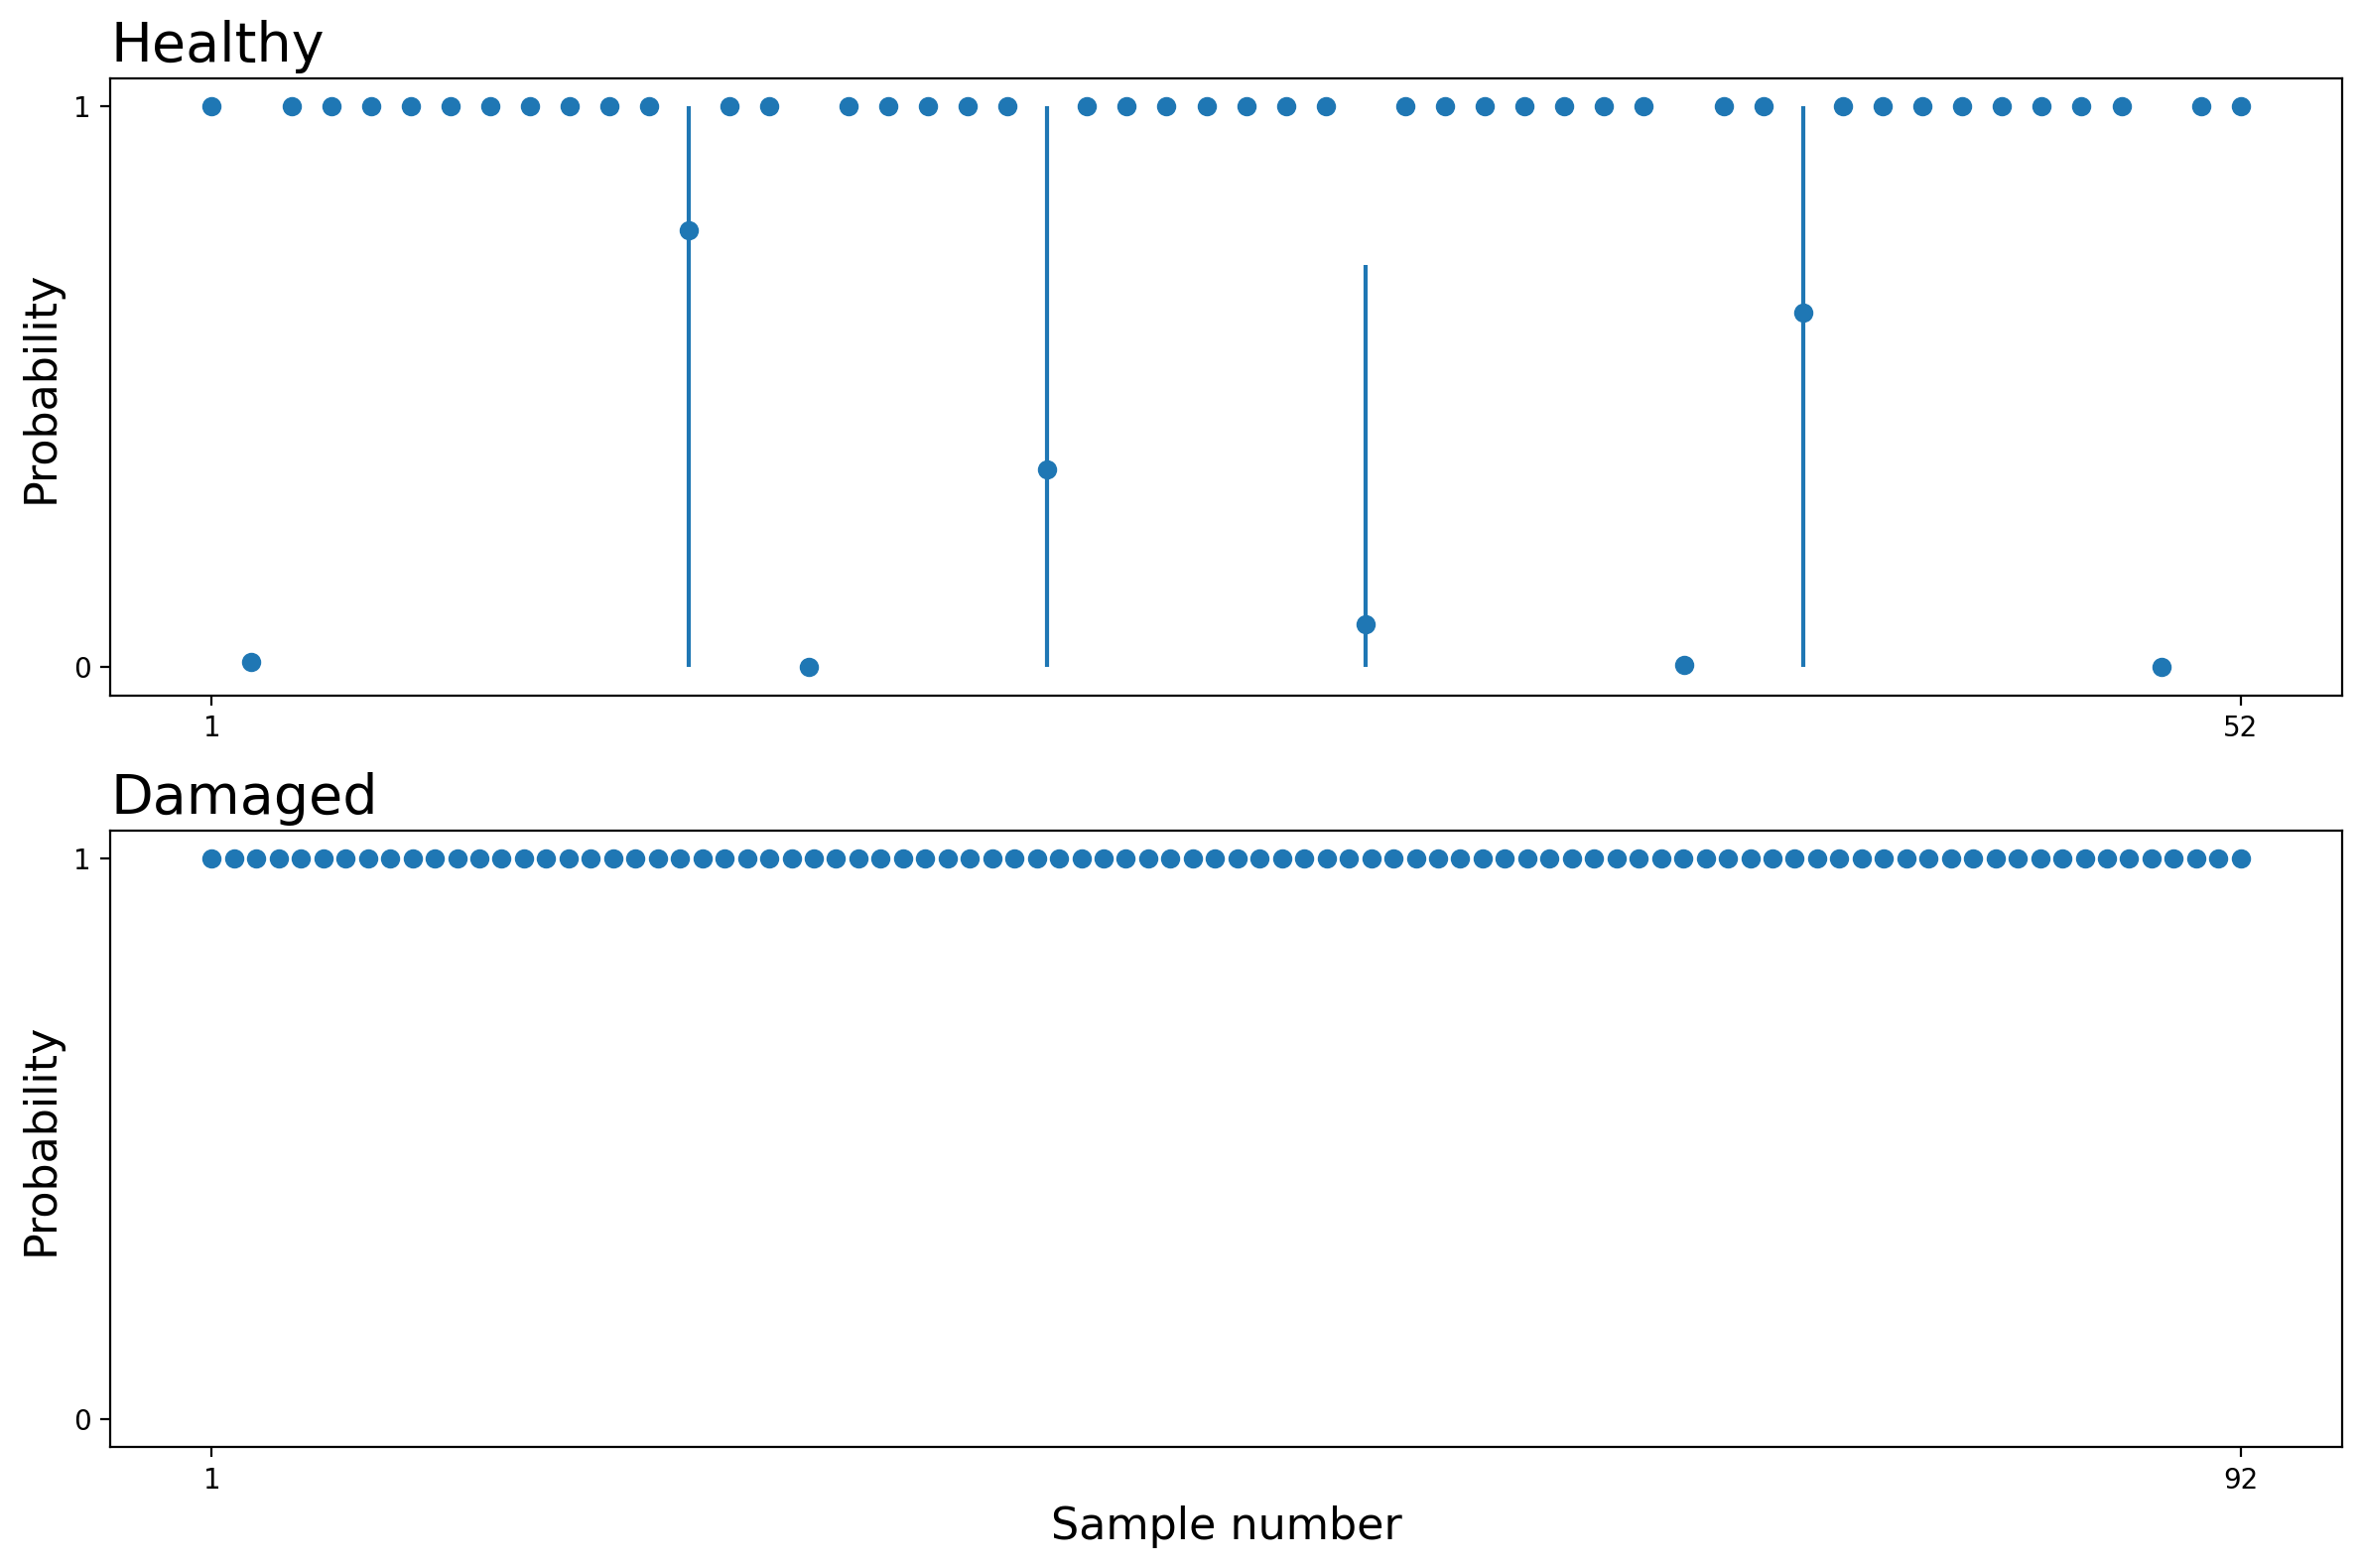

In [8]:
num_knots = 15
frequencies = gyro_agg_15['Frequencies']
data, labels, IT, IL, total,B0,knot_list,N = prepare_data(acc,frequencies=None,training_samples=[7,7], 
                                                        num_knots=num_knots, mode = 'binary')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
samples = get_results(model=model,data=data,labels=labels,IT=IT,IL=IL,total=total,mode='binary',plot=True,N=N)

13:02:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:02:54 - cmdstanpy - INFO - CmdStan done processing.
13:02:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/posterior_check.stan', line 22, column 4 to column 30)
Consider re-running with show_console=True if the above output is unclear!


13:02:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:02:56 - cmdstanpy - INFO - CmdStan done processing.


13:02:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:02:58 - cmdstanpy - INFO - CmdStan done processing.
13:02:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/posterior_check.stan', line 22, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/posterior_check.stan', line 22, column 4 to column 30)
Consider re-running with show_console=True if the above output is unclear!


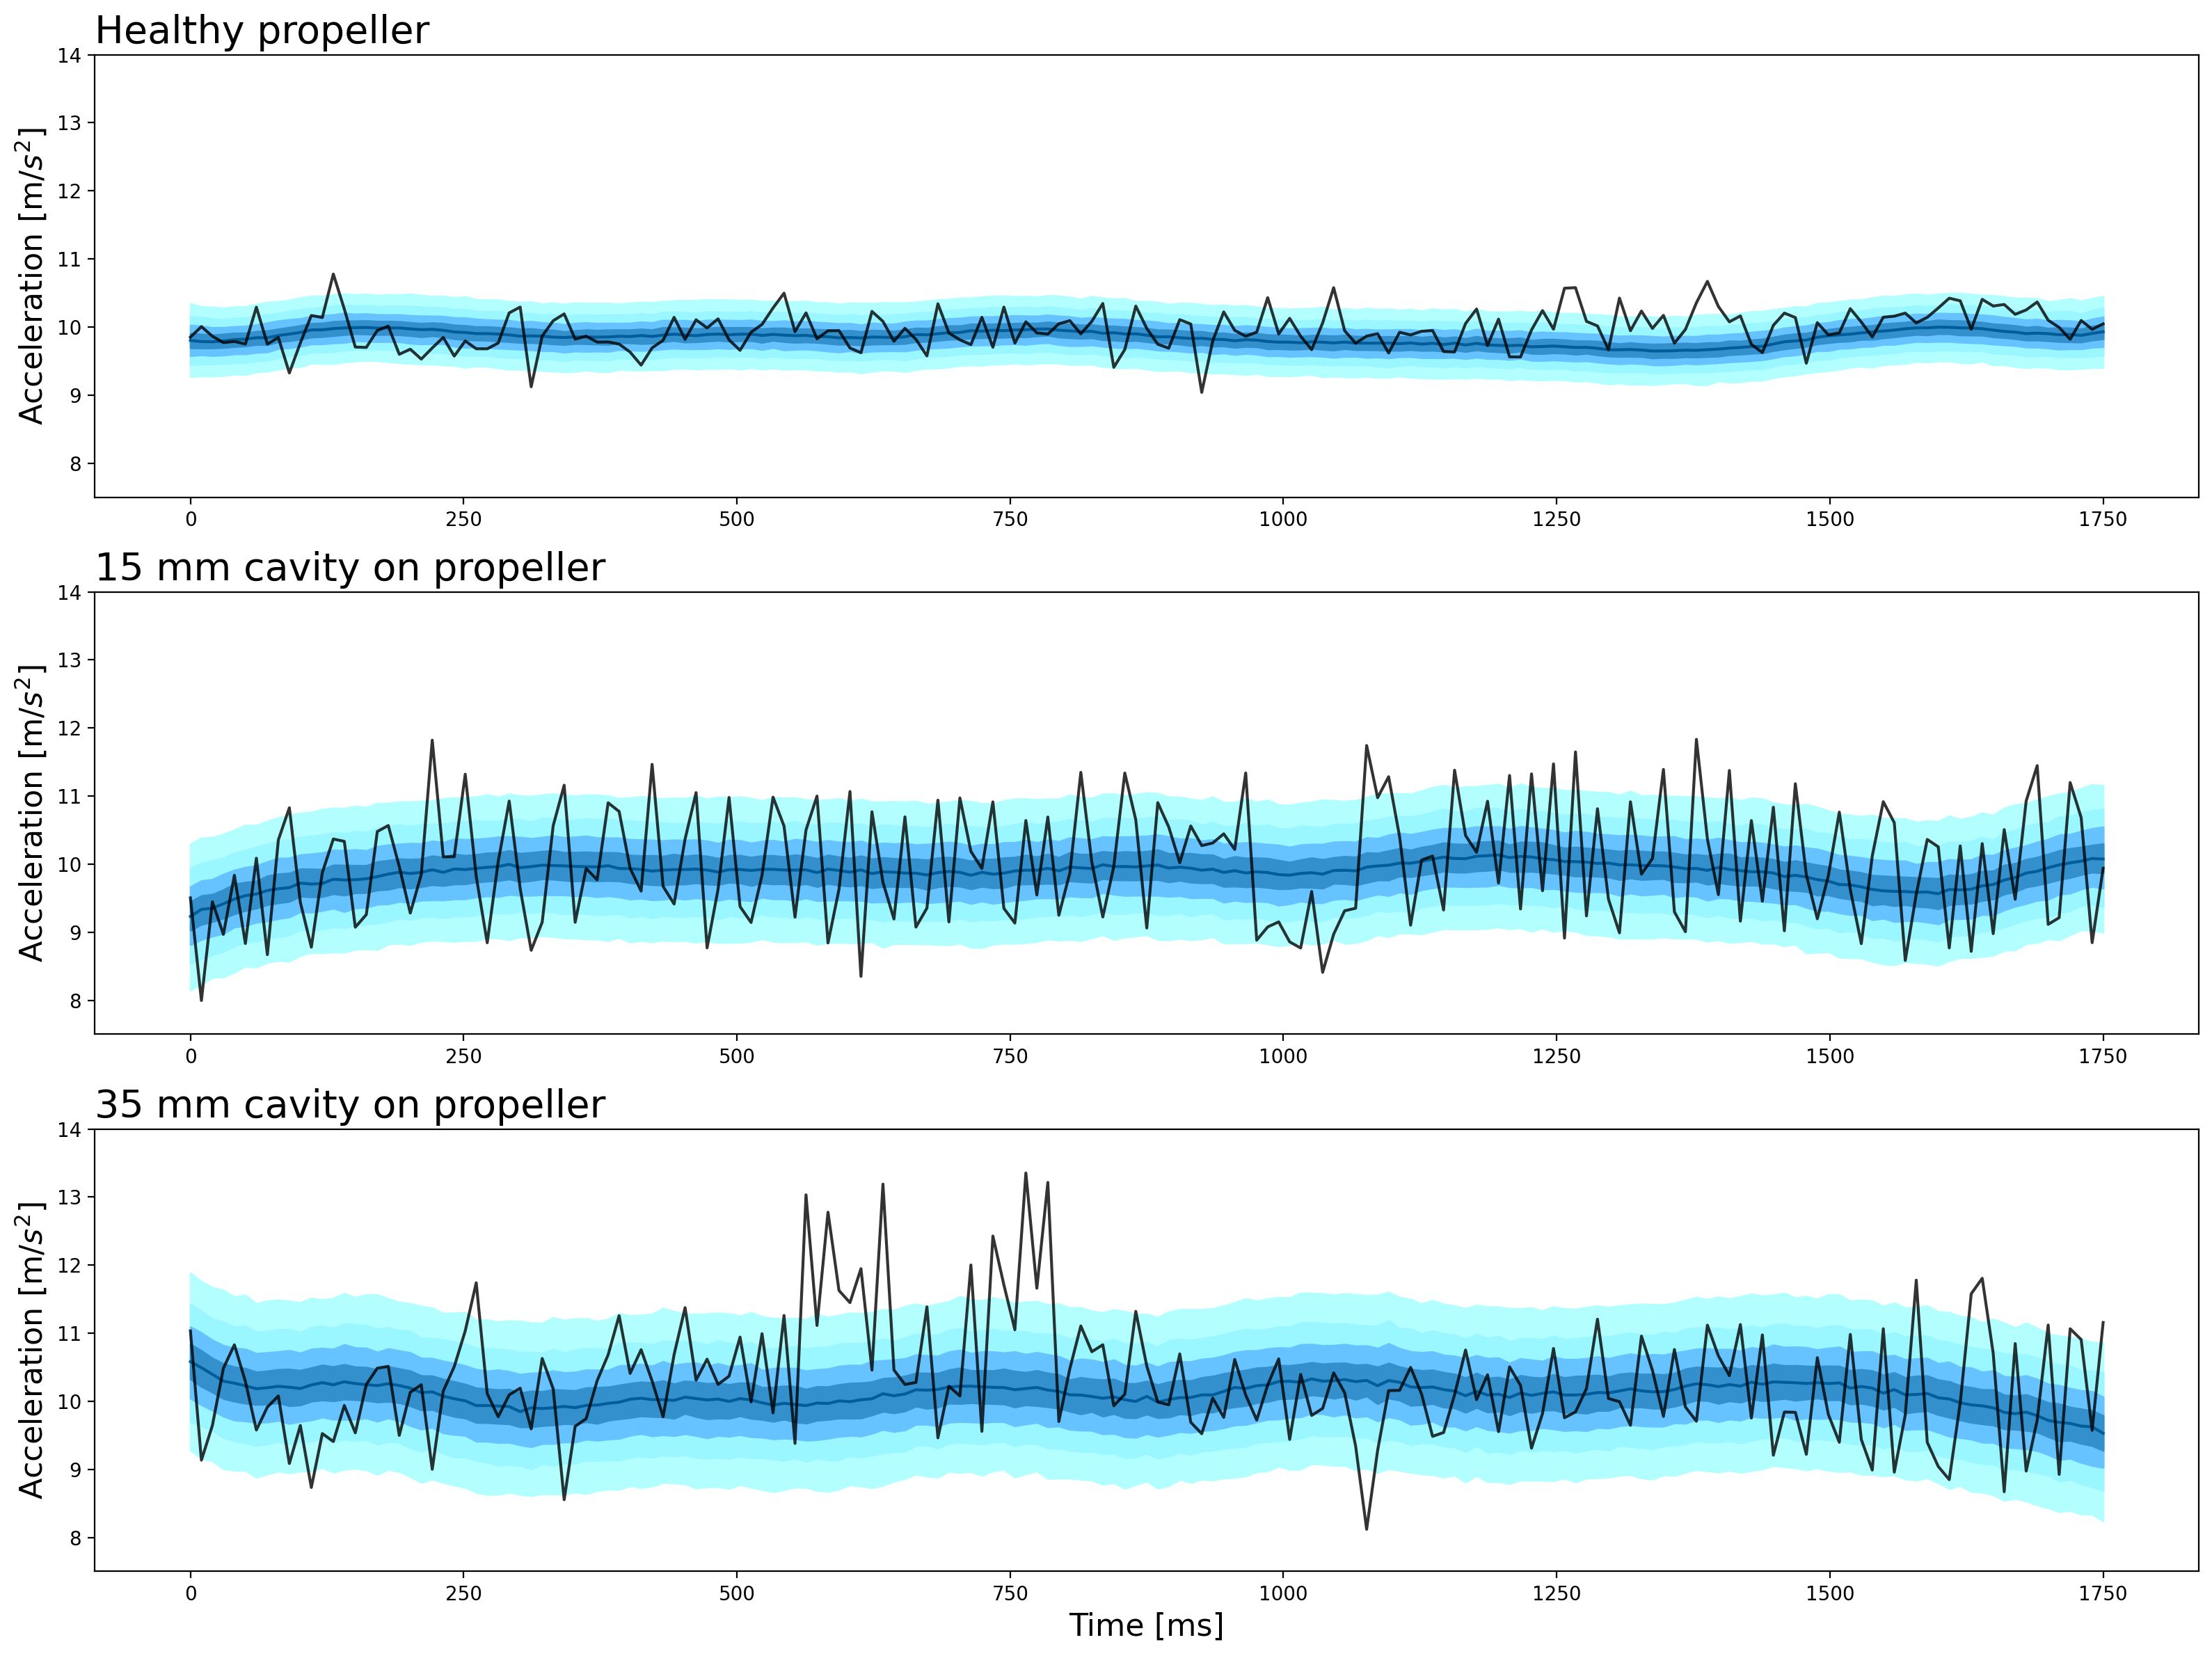

In [9]:
model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 15
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior1 = model_posterior.sample(data=data_ppc)
fig,axes = plt.subplots(3,1,figsize=[16,12],tight_layout=True)

x = np.linspace(0,1750,175)
y_pred1= samples_posterior1.stan_variable('y_hat')[:,:]
axes[0] = ribbon_plot(x,y_pred1,axes[0],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[0].set_ylabel('Acceleration [m/$s^2$]',fontsize = 16)
axes[0].set_title('Healthy propeller', loc= 'left',fontsize = 20)
axes[0].plot(x,acc_healthy_data[32], color = 'k',alpha=0.8)

model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 13
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[1]))])
y = acc[1][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior2 = model_posterior.sample(data=data_ppc)

y_pred2= samples_posterior2.stan_variable('y_hat')[:,:]
axes[1] = ribbon_plot(x,y_pred2,axes[1],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[1].set_ylabel('Acceleration [m/$s^2$]',fontsize = 16)
axes[1].set_title('15 mm cavity on propeller', loc= 'left',fontsize = 20)
axes[1].plot(x,acc_15_data[10], color = 'k',alpha=0.8)



model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 8
num_knots = 13
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[2]))])
y = acc[2][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior3 = model_posterior.sample(data=data_ppc)

y_pred3= samples_posterior3.stan_variable('y_hat')[:,:]
axes[2] = ribbon_plot(x,y_pred3,axes[2],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[2].set_ylabel('Acceleration [m/$s^2$]',fontsize = 16)
axes[2].set_title('35 mm cavity on propeller', loc= 'left',fontsize = 20)
axes[2].plot(x,acc_35_data[10], color = 'k',alpha=0.8)
axes[2].set_xlabel('Time [ms]',fontsize = 16)


axes[0].set_ylim(7.5,14)
axes[1].set_ylim(7.5,14)
axes[2].set_ylim(7.5,14)

fig.savefig('plots/gen_acc.jpg')

In [10]:
num_knots = 18
data, labels, IT, IL, total,B0,knot_list,n = prepare_data(acc,frequencies=None,training_samples=[7,7,7], 
                                                        num_knots=num_knots, mode = 'all')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
res,indicies = get_results(model=model,data=data,seed=seed,labels=labels,IT=IT,IL=IL,total=total,mode='all',plot=True)

13:03:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:03:09 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.7007299270072993


In [11]:
probs = res.stan_variable('probabilities')
az.summary(res, var_names=[
    'probabilities'])

/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"probabilities[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0, 1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0, 2]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0, 3]",0.998,0.035,1.000,1.000,0.001,0.000,3371.0,3367.0,1.0
"probabilities[0, 4]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
"probabilities[2, 132]",0.989,0.072,0.985,1.000,0.001,0.001,4864.0,3839.0,1.0
"probabilities[2, 133]",0.829,0.287,0.132,1.000,0.005,0.003,5161.0,3471.0,1.0
"probabilities[2, 134]",0.005,0.034,0.000,0.010,0.001,0.000,4933.0,3185.0,1.0
"probabilities[2, 135]",0.418,0.406,0.000,0.998,0.006,0.004,4465.0,3216.0,1.0


In [12]:
az.summary(res, var_names=[
    'probabilities'])

/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"probabilities[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0, 1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0, 2]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0, 3]",0.998,0.035,1.000,1.000,0.001,0.000,3371.0,3367.0,1.0
"probabilities[0, 4]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
"probabilities[2, 132]",0.989,0.072,0.985,1.000,0.001,0.001,4864.0,3839.0,1.0
"probabilities[2, 133]",0.829,0.287,0.132,1.000,0.005,0.003,5161.0,3471.0,1.0
"probabilities[2, 134]",0.005,0.034,0.000,0.010,0.001,0.000,4933.0,3185.0,1.0
"probabilities[2, 135]",0.418,0.406,0.000,0.998,0.006,0.004,4465.0,3216.0,1.0


In [13]:
x = [probs[:,0,0],probs[:,0,135]]
y = [probs[:,1,0],probs[:,1,135]]
z = [probs[:,2,0],probs[:,2,135]]

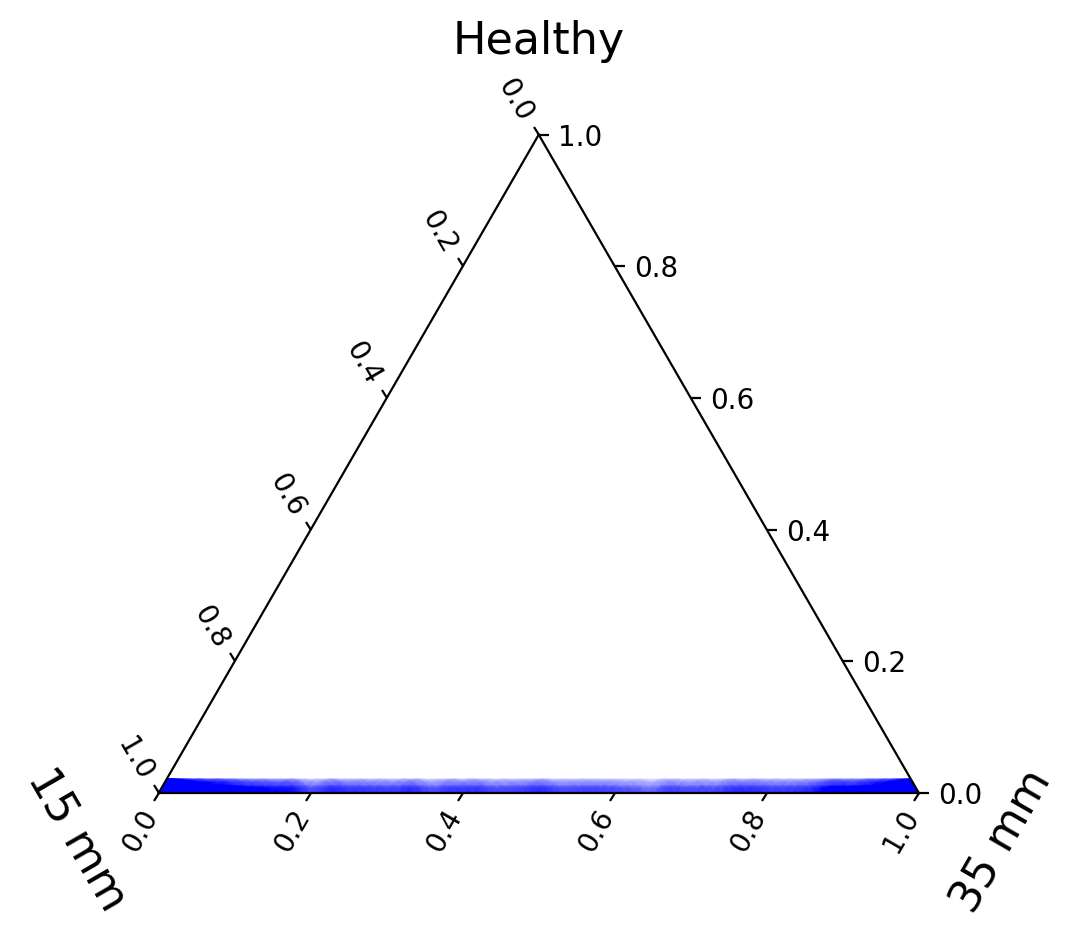

In [14]:
import mpltern 

fig = plt.figure(tight_layout=True)
fig.subplots_adjust(wspace=0.3)

positions = ['tick1']
for i, position in enumerate(positions):
    ax = fig.add_subplot(1, 1, i + 1, projection='ternary')

    ax.set_tlabel('Healthy', fontsize=16)
    ax.set_llabel('15 mm', fontsize=16)
    ax.set_rlabel('35 mm', fontsize=16)
    ax.scatter(x[1], y[1], z[1], c = 'blue',alpha = 0.01,linewidths=5)
    ax.set_title(f"", pad=42)

plt.show()
fig.savefig('plots/three_bad.jpg')

/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


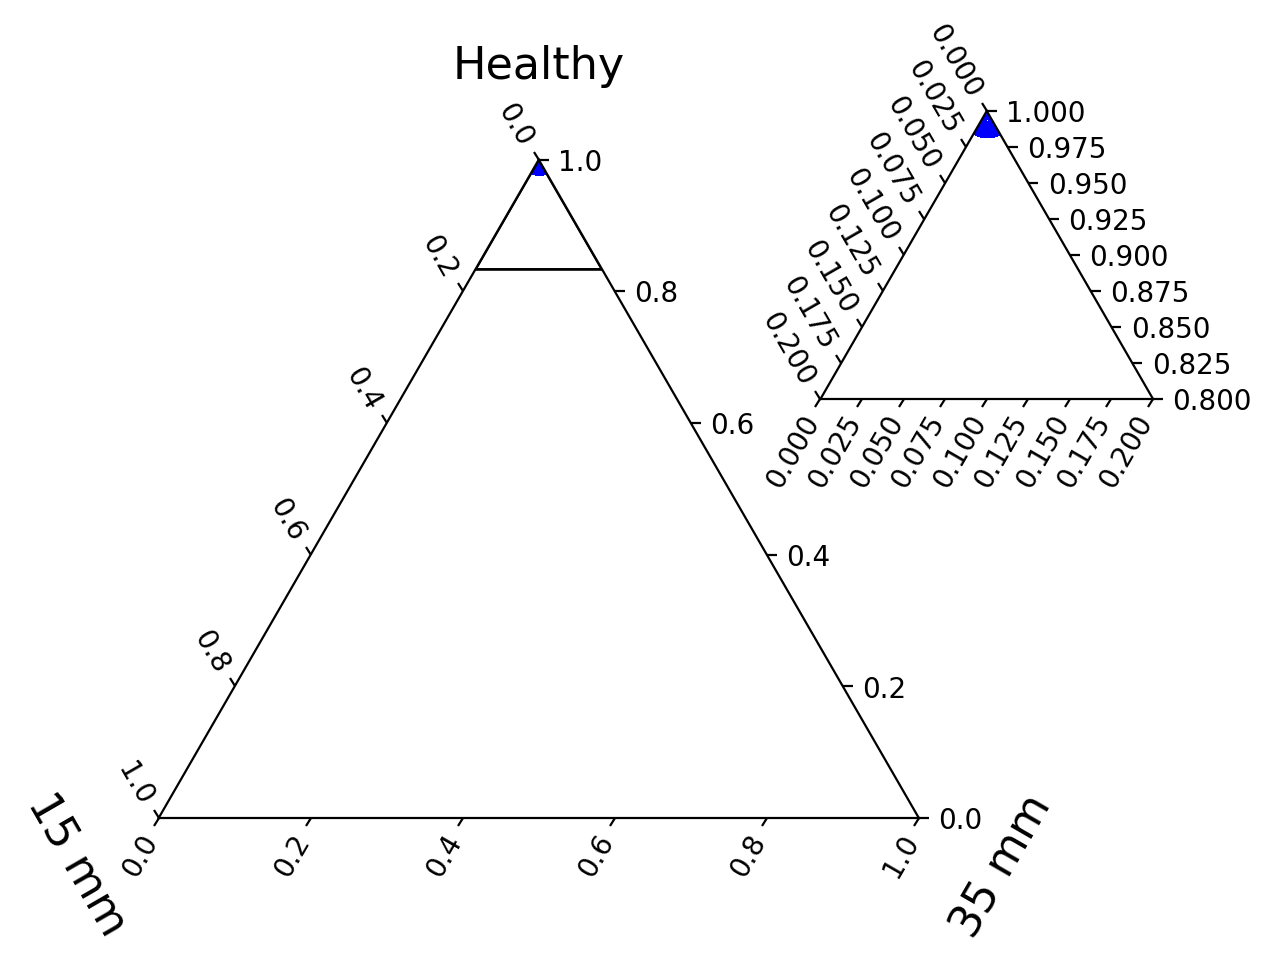

/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_74101/460069181.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('plots/3class_good.jpg')


In [15]:
fig = plt.figure(tight_layout=True)
fig.subplots_adjust(left=-0.1)

ax = fig.add_subplot(projection="ternary")

ax.scatter(x[0], y[0], z[0], c = 'blue',alpha = 0.1,linewidths=5)

# Plot the triangle region for the inset.
ax.fill([1, 1, 1],[0,0.2, 0], [ 0, 0,0.2],  fc="none", ec="k")
ax.set_tlabel('Healthy', fontsize=16)
ax.set_rlabel('35 mm', fontsize=16)
ax.set_llabel('15 mm', fontsize=16)
# Create a new `TernaryAxes` for the inset with specifying a rectangle in the
# figure coordinates.
axins = fig.add_axes([0.7, 0.6, 0.30, 0.30], projection="ternary")

# Limit the ploting range to be consistent with the above plotted triangle.
axins.set_ternary_min(0.8, 0, 0)
axins.set_ternary_max(1, 0.2, 0.2)

axins.scatter(x[0], y[0], z[0], c = 'blue', linewidths=13)

plt.show()
fig.savefig('plots/3class_good.jpg')

WAIC criterion to determine number of splines

In [20]:
I = 5
num_knots = 10
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]
data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior10 = model_posterior.sample(data=data_ppc)

13:07:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:08:00 - cmdstanpy - INFO - CmdStan done processing.


In [21]:
model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 15
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior15 = model_posterior.sample(data=data_ppc)

13:08:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:08:03 - cmdstanpy - INFO - CmdStan done processing.


In [22]:
I = 5
num_knots = 20
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]
data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior20 = model_posterior.sample(data=data_ppc)

13:08:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:08:04 - cmdstanpy - INFO - CmdStan done processing.


In [23]:
I = 5
num_knots = 25
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]
data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior25 = model_posterior.sample(data=data_ppc)

13:08:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:08:07 - cmdstanpy - INFO - CmdStan done processing.


In [24]:
I = 5
num_knots = 30
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]
data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior30 = model_posterior.sample(data=data_ppc)

13:08:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:08:09 - cmdstanpy - INFO - CmdStan done processing.


/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kacperjarzyna/opt/anaconda3/envs/stan/lib/python3.12/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kacperjarzyna/opt/anacon

            rank    elpd_waic     p_waic    elpd_diff        weight  \
10 splines     0  -402.813769   8.131582     0.000000  4.882549e-01   
20 splines     1  -432.602184  13.237405    29.788415  3.508138e-01   
25 splines     2  -461.057720  14.537977    58.243951  1.494353e-01   
15 splines     3  -497.818731  10.258668    95.004962  1.149601e-02   
30 splines     4  -553.727954  17.002246   150.914186  1.954386e-09   
50 splines     5 -3027.321981  32.064044  2624.508212  0.000000e+00   

                   se        dse  warning scale  
10 splines  23.222327   0.000000     True   log  
20 splines  27.812200  37.797115     True   log  
25 splines  26.513560  37.628152     True   log  
15 splines  26.883104  35.756860     True   log  
30 splines  24.161622  31.379400     True   log  
50 splines   2.661499  23.412862     True   log  


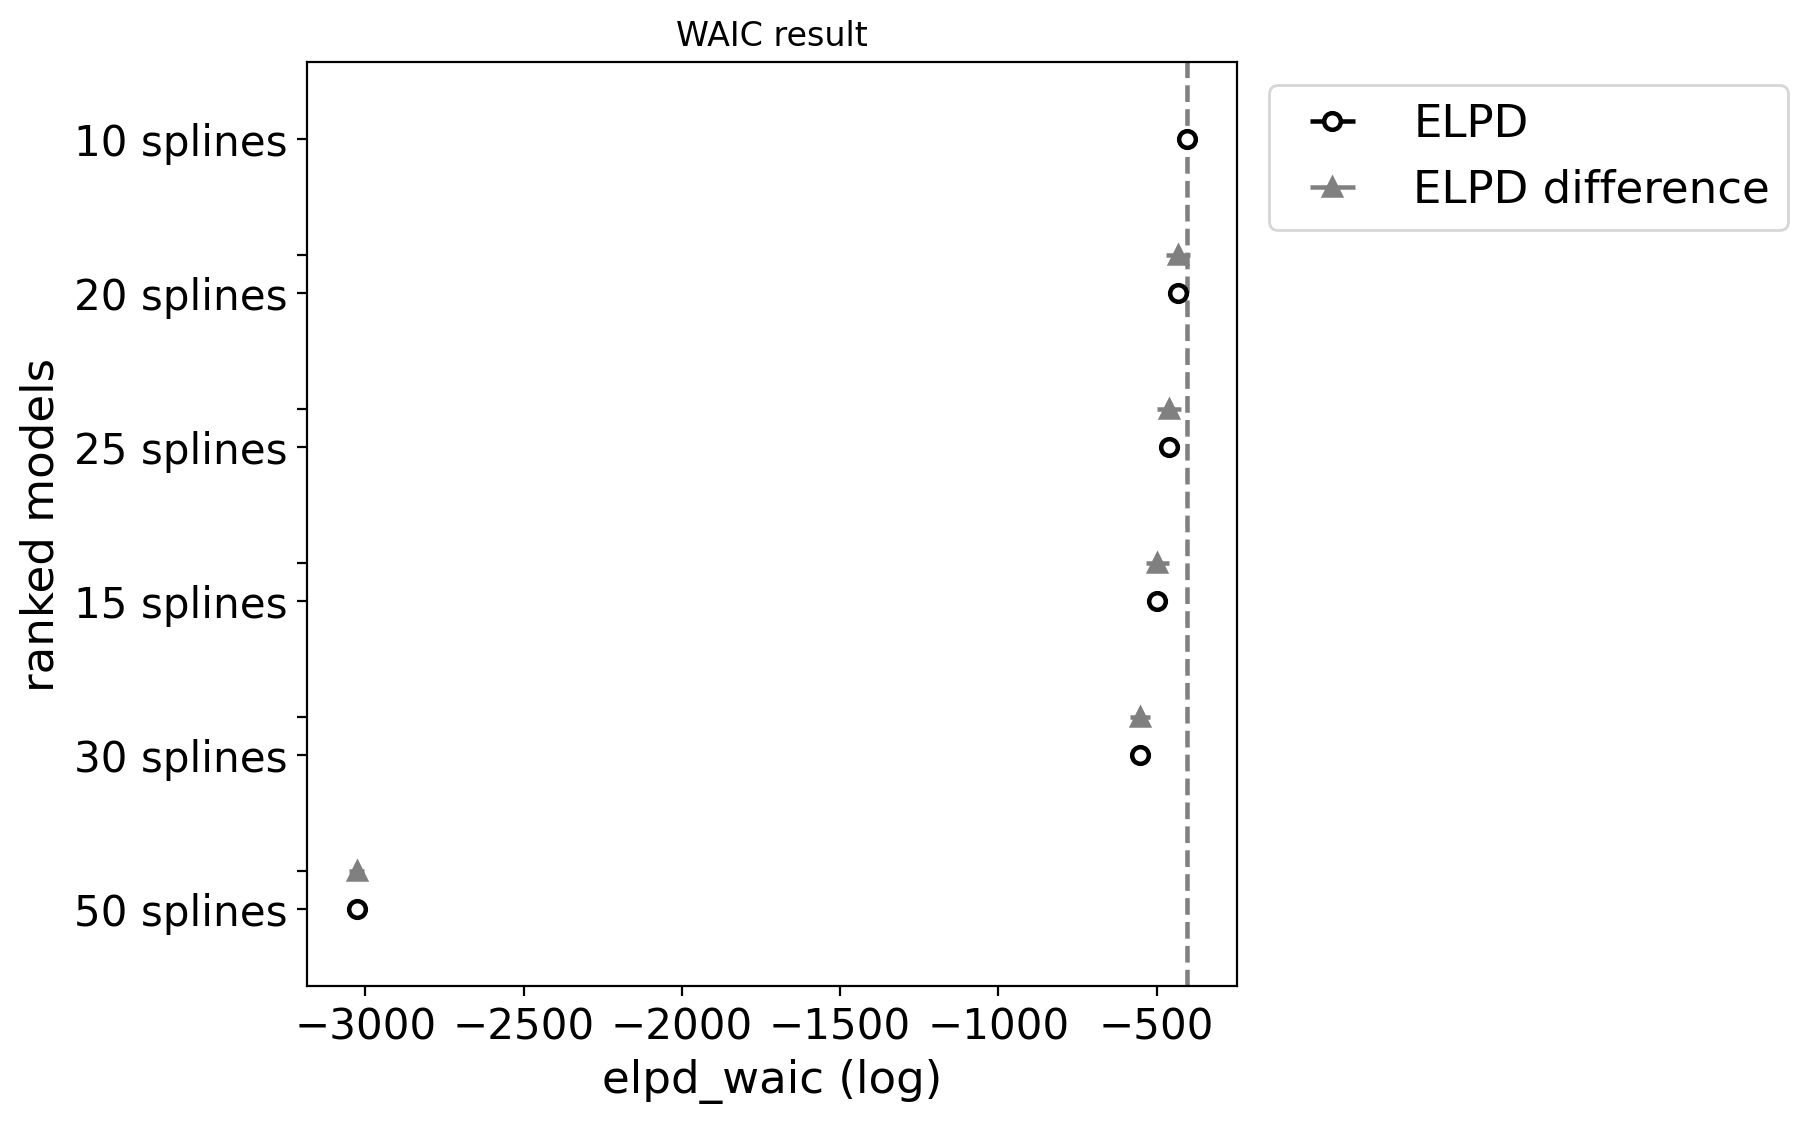

In [28]:
splines_10_data = az.from_cmdstanpy(posterior=samples_posterior10,log_likelihood='log_lik',
                          posterior_predictive='y_hat')
splines_15_data = az.from_cmdstanpy(posterior=samples_posterior15,log_likelihood='log_lik',
                          posterior_predictive='y_hat')

splines_20_data = az.from_cmdstanpy(posterior=samples_posterior20,log_likelihood='log_lik',
                          posterior_predictive='y_hat')
splines_25_data = az.from_cmdstanpy(posterior=samples_posterior25,log_likelihood='log_lik',
                          posterior_predictive='y_hat')
splines_30_data = az.from_cmdstanpy(posterior=samples_posterior30,log_likelihood='log_lik',
                          posterior_predictive='y_hat')

comparison_waic = az.compare({'10 splines': splines_10_data, '15 splines' : splines_15_data, '20 splines' : splines_20_data,'25 splines': splines_25_data, '30 splines' : splines_30_data}, ic="waic")
print(comparison_waic)
az.plot_compare(comparison_waic)
plt.title('WAIC result')
plt.show()

In [39]:
model = CmdStanModel(stan_file='stan/mix.stan')
knots = [10,15,20,25,30]
num_iters = 10
# accelerometer with data aggregation in the time domain
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total ,B0, knot_list,N = prepare_data(acc, frequencies=None, training_samples=[7,7], num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary')[0])
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('res_new/test_bin_agg_results.csv')

# model = CmdStanModel(stan_file='stan/mix.stan')
# frequencies = gyro_damaged['Frequencies']

# # gyroscope without data aggregation in the frequency domain
# result_dict_gyro = {}
# for num_knots in knots:
#     res = []
#     for i in range(num_iters):
#         data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
#         res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
#     result_dict_gyro[f'Spline {num_knots}'] = np.mean(res)
#     pd_res = pd.DataFrame(result_dict_gyro,index=[0])
#     pd_res.to_csv('res_new/gyro_results.csv')

# # gyroscope with data aggregation in the frequency domain
# result_dict_gyro_agg = {}
# for num_knots in knots:
#     res = []
#     for i in range(num_iters):
#         data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro_agg, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
#         res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
#     result_dict_gyro_agg[f'Spline {num_knots}'] = np.mean(res)
#     pd_res = pd.DataFrame(result_dict_gyro_agg,index=[0])
#     pd_res.to_csv('res_new/gyro_agg_results.csv')

13:55:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:55:17 - cmdstanpy - INFO - CmdStan done processing.


13:55:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:55:26 - cmdstanpy - INFO - CmdStan done processing.


13:55:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:55:36 - cmdstanpy - INFO - CmdStan done processing.


13:55:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9375


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:55:46 - cmdstanpy - INFO - CmdStan done processing.


13:55:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:55:55 - cmdstanpy - INFO - CmdStan done processing.


13:55:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:56:05 - cmdstanpy - INFO - CmdStan done processing.


13:56:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:56:16 - cmdstanpy - INFO - CmdStan done processing.


13:56:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
13:56:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:56:25 - cmdstanpy - INFO - CmdStan done processing.


13:56:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:56:34 - cmdstanpy - INFO - CmdStan done processing.


13:56:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:56:44 - cmdstanpy - INFO - CmdStan done processing.


13:56:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:56:54 - cmdstanpy - INFO - CmdStan done processing.


13:56:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:57:03 - cmdstanpy - INFO - CmdStan done processing.


13:57:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:57:13 - cmdstanpy - INFO - CmdStan done processing.


13:57:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:57:23 - cmdstanpy - INFO - CmdStan done processing.


13:57:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:57:33 - cmdstanpy - INFO - CmdStan done processing.


13:57:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9444444444444444


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:57:43 - cmdstanpy - INFO - CmdStan done processing.


13:57:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:57:54 - cmdstanpy - INFO - CmdStan done processing.


13:57:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
13:57:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:58:04 - cmdstanpy - INFO - CmdStan done processing.


13:58:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:58:14 - cmdstanpy - INFO - CmdStan done processing.


13:58:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:58:24 - cmdstanpy - INFO - CmdStan done processing.


13:58:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:58:34 - cmdstanpy - INFO - CmdStan done processing.


13:58:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:58:45 - cmdstanpy - INFO - CmdStan done processing.


13:58:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:58:56 - cmdstanpy - INFO - CmdStan done processing.


13:58:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:59:08 - cmdstanpy - INFO - CmdStan done processing.


13:59:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:59:19 - cmdstanpy - INFO - CmdStan done processing.


13:59:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:59:30 - cmdstanpy - INFO - CmdStan done processing.


13:59:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:59:41 - cmdstanpy - INFO - CmdStan done processing.


13:59:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:59:51 - cmdstanpy - INFO - CmdStan done processing.


13:59:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:00:02 - cmdstanpy - INFO - CmdStan done processing.


14:00:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:00:12 - cmdstanpy - INFO - CmdStan done processing.


14:00:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:00:25 - cmdstanpy - INFO - CmdStan done processing.


14:00:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:00:36 - cmdstanpy - INFO - CmdStan done processing.


14:00:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
14:00:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:00:48 - cmdstanpy - INFO - CmdStan done processing.


14:00:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:00:59 - cmdstanpy - INFO - CmdStan done processing.


14:01:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:01:12 - cmdstanpy - INFO - CmdStan done processing.


14:01:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:01:23 - cmdstanpy - INFO - CmdStan done processing.


14:01:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:01:36 - cmdstanpy - INFO - CmdStan done processing.


14:01:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:01:49 - cmdstanpy - INFO - CmdStan done processing.


14:01:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:01 - cmdstanpy - INFO - CmdStan done processing.


14:02:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:13 - cmdstanpy - INFO - CmdStan done processing.


14:02:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:25 - cmdstanpy - INFO - CmdStan done processing.


14:02:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
14:02:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:37 - cmdstanpy - INFO - CmdStan done processing.


14:02:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:02:48 - cmdstanpy - INFO - CmdStan done processing.


14:02:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:03:00 - cmdstanpy - INFO - CmdStan done processing.


14:03:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:03:11 - cmdstanpy - INFO - CmdStan done processing.


14:03:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:03:23 - cmdstanpy - INFO - CmdStan done processing.


14:03:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:03:34 - cmdstanpy - INFO - CmdStan done processing.


14:03:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:03:46 - cmdstanpy - INFO - CmdStan done processing.


14:03:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:03:57 - cmdstanpy - INFO - CmdStan done processing.


14:03:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:04:10 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9722222222222222


In [38]:
model = CmdStanModel(stan_file='stan/mix.stan')
knots = [10,15,20,25,30]
num_iters = 10
# accelerometer with data aggregation in the time domain
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total ,B0, knot_list,N = prepare_data(acc, frequencies=None, training_samples=[7,5,7], num_knots=num_knots, mode = 'all')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='all')[0])
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('res_new/test_agg_results.csv')

13:41:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:41:53 - cmdstanpy - INFO - CmdStan done processing.


13:41:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6690647482014389


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:42:07 - cmdstanpy - INFO - CmdStan done processing.


13:42:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:42:21 - cmdstanpy - INFO - CmdStan done processing.


13:42:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7553956834532374


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:42:35 - cmdstanpy - INFO - CmdStan done processing.


13:42:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7122302158273381


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:42:48 - cmdstanpy - INFO - CmdStan done processing.


13:42:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6546762589928057


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:43:02 - cmdstanpy - INFO - CmdStan done processing.


13:43:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7338129496402878


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:43:15 - cmdstanpy - INFO - CmdStan done processing.


13:43:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7482014388489209


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:43:28 - cmdstanpy - INFO - CmdStan done processing.


13:43:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:43:40 - cmdstanpy - INFO - CmdStan done processing.


13:43:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7410071942446044


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:43:53 - cmdstanpy - INFO - CmdStan done processing.


13:43:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.618705035971223


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:44:08 - cmdstanpy - INFO - CmdStan done processing.


13:44:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6546762589928057


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:44:22 - cmdstanpy - INFO - CmdStan done processing.


13:44:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:44:37 - cmdstanpy - INFO - CmdStan done processing.


13:44:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:44:53 - cmdstanpy - INFO - CmdStan done processing.


13:44:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7122302158273381


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:45:09 - cmdstanpy - INFO - CmdStan done processing.


13:45:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:45:24 - cmdstanpy - INFO - CmdStan done processing.


13:45:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:45:38 - cmdstanpy - INFO - CmdStan done processing.


13:45:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:45:53 - cmdstanpy - INFO - CmdStan done processing.


13:45:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7769784172661871


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:46:07 - cmdstanpy - INFO - CmdStan done processing.


13:46:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:46:21 - cmdstanpy - INFO - CmdStan done processing.


13:46:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
13:46:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6690647482014389


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:46:37 - cmdstanpy - INFO - CmdStan done processing.


13:46:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.5755395683453237


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:46:52 - cmdstanpy - INFO - CmdStan done processing.


13:46:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7482014388489209


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:08 - cmdstanpy - INFO - CmdStan done processing.


13:47:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6690647482014389


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:23 - cmdstanpy - INFO - CmdStan done processing.


13:47:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7553956834532374


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:39 - cmdstanpy - INFO - CmdStan done processing.


13:47:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:47:55 - cmdstanpy - INFO - CmdStan done processing.


13:47:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:48:11 - cmdstanpy - INFO - CmdStan done processing.


13:48:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7266187050359711


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:48:26 - cmdstanpy - INFO - CmdStan done processing.


13:48:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7553956834532374


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:48:42 - cmdstanpy - INFO - CmdStan done processing.


13:48:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7482014388489209


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:48:58 - cmdstanpy - INFO - CmdStan done processing.


13:49:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:49:15 - cmdstanpy - INFO - CmdStan done processing.


13:49:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6906474820143884


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:49:32 - cmdstanpy - INFO - CmdStan done processing.


13:49:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7769784172661871


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:49:49 - cmdstanpy - INFO - CmdStan done processing.


13:49:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6115107913669064


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:50:07 - cmdstanpy - INFO - CmdStan done processing.


13:50:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6474820143884892


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:50:25 - cmdstanpy - INFO - CmdStan done processing.


13:50:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7410071942446044


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:50:43 - cmdstanpy - INFO - CmdStan done processing.


13:50:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:51:00 - cmdstanpy - INFO - CmdStan done processing.


13:51:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.5827338129496402


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:51:17 - cmdstanpy - INFO - CmdStan done processing.


13:51:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:51:35 - cmdstanpy - INFO - CmdStan done processing.


13:51:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7338129496402878


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:51:53 - cmdstanpy - INFO - CmdStan done processing.


13:51:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:52:11 - cmdstanpy - INFO - CmdStan done processing.


13:52:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7697841726618705


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:52:29 - cmdstanpy - INFO - CmdStan done processing.


13:52:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7913669064748201


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:52:50 - cmdstanpy - INFO - CmdStan done processing.


13:52:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7266187050359711


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:53:09 - cmdstanpy - INFO - CmdStan done processing.


13:53:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7410071942446044


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:53:28 - cmdstanpy - INFO - CmdStan done processing.


13:53:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7266187050359711


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:53:48 - cmdstanpy - INFO - CmdStan done processing.


13:53:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:54:08 - cmdstanpy - INFO - CmdStan done processing.


13:54:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6474820143884892


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:54:28 - cmdstanpy - INFO - CmdStan done processing.


13:54:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6402877697841727


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:54:48 - cmdstanpy - INFO - CmdStan done processing.


13:54:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.5683453237410072


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:55:07 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.6474820143884892
